# Calculating charges of one molecule with a temporary server


In this tutorial, we calculate the RESP charges of one molecule with a temporary server.

In [1]:
import psiresp

## Creating the molecule

Let's choose a small molecule (DMSO) at a
low level of theory so that computations finish in a manageable
amount of time. I will use the RDKit 
package to create the molecule from SMILES. 

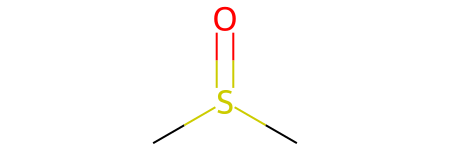

In [2]:
from rdkit import Chem
rd_dmso = Chem.MolFromSmiles("CS(=O)C")
rd_dmso

Below we set up a PsiRESP molecule. Nothing is executed when we first create it; the `optimize_geometry` flag simply tells a `Job` whether or not to optimize conformers. Note that no conformers are present when the molecule is first created.

In [3]:
dmso = psiresp.Molecule.from_rdkit(rd_dmso, optimize_geometry=True)
print(dmso.conformers)

[]


As only a SMILES string was given as input, a random conformer was generated for the QCElemental molecule. 

In [4]:
dmso.qcmol

NGLWidget()

A picture is provided below if the NGLView widget does not appear.

![dmso](images/dmso.png)

## Setting up a server

As this tutorial is written and running in a Jupyter notebook, we will use QCFractal's `FractalSnowflakeHandler` as a server. For Python scripts, it is recommended to use `psiresp.testing.FractalSnowflake` instead, a patch of QCFractal's `FractalSnowflake`; and on HPC computing clusters, to use QCFractal's `FractalServer`.

In [5]:
from qcfractal import FractalSnowflakeHandler

server = FractalSnowflakeHandler()
print(server)

FractalSnowflakeHandler(name='db_94eb7466_da89_4500_9787_0b8c2ed9d723' uri='https://localhost:65393')


We need to create a client to talk to the server.

In [6]:
client = server.client()
print(client)

FractalClient(server_name='FractalSnowFlake_db_94eb7', address='https://localhost:65393/', username='None')


## Setting up the job

Let's first set up some job options. The typical method and basis set for QM computation are "hg/6-31g*", but we go with "b3lyp/sto-3g" here to save time.

In [7]:
geometry_options = psiresp.QMGeometryOptimizationOptions(
    method="b3lyp", basis="sto-3g")
esp_options = psiresp.QMEnergyOptions(
    method="b3lyp", basis="sto-3g",
)

Below are the full keywords that can be customised:

In [8]:
geometry_options

QMGeometryOptimizationOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization')

In [9]:
esp_options

QMEnergyOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, jobname='single_point')

`pcm_options` controls solvation options, should you wish to run the QM computations in solvent. The default options look like:

In [10]:
psiresp.qm.PCMOptions()

PCMOptions(medium_solver_type='CPCM', medium_solvent='water', cavity_radii_set='Bondi', cavity_type='GePol', cavity_scaling=True, cavity_area=0.3, cavity_mode='Implicit')

Note that these are easily transferrable as JSON objects:

In [11]:
geometry_options.json()

'{"method": "b3lyp", "basis": "sto-3g", "pcm_options": null, "driver": "gradient", "query_interval": 20, "protocols": {"wavefunction": "orbitals_and_eigenvalues"}, "g_convergence": "gau_tight", "max_iter": 200, "full_hess_every": 10, "jobname": "optimization"}'

The default RESP options in PsiRESP make for what can be considered
canonical RESP: a 2-stage restrained fit, where hydrogens are
excluded from the restraint, and the scale factors for the asymptote
limits of the hyperbola restraint are 0.0005 and 0.001 for the first
and second stage respectively.

Let's have a look at everything we can characterize.

In [12]:
resp_options = psiresp.RespOptions()
resp_options

RespOptions(restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, restraint_height_stage_1=0.0005, restraint_height_stage_2=0.001, stage_2=True)

Now let's create a PsiRESP job. If we inspect all the possible options, you can see that you can specify grid options (to create the grid for which the ESP is evaluated), and charge constraint options (for setting charge restraints). We will leave these as defaults for now.

In [13]:
job = psiresp.Job(molecules=[dmso],
                qm_optimization_options=geometry_options,
                qm_esp_options=esp_options,
                resp_options=resp_options)
job

Job(molecules=[Molecule(name=C2H6OS, charge=0) with 0 conformers], qm_optimization_options=QMGeometryOptimizationOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='gradient', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, g_convergence='gau_tight', max_iter=200, full_hess_every=10, jobname='optimization'), qm_esp_options=QMEnergyOptions(method='b3lyp', basis='sto-3g', pcm_options=None, driver='energy', query_interval=20, protocols={'wavefunction': 'orbitals_and_eigenvalues'}, jobname='single_point'), grid_options=GridOptions(grid_rmin=0, grid_rmax=-1, use_radii='msk', vdw_radii={}, vdw_scale_factors=[1.4, 1.6, 1.8, 2.0], vdw_point_density=1.0), resp_options=RespOptions(restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, restraint_height_stage_1=0.0005, restraint_height_stage_2=0.001, stage_2=True), charge_constraints=ChargeConstraintOptions(charge_sum_constraints=[], charge_equivalence_c

## Running the job

Now let's run the job. This might take some time, as it requires optimizing geometries and computing single points, all on your device. If you do not pass a client, the job will instead write Psi4 job files, and exit.

In [14]:
job.run(client=client)
print(job.charges)

compute-esp: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]


[array([-0.2536612209746995,  0.285266214850886 , -0.2933165843540106,
       -0.2377672942508635,  0.0854041134814578,  0.0854041134814578,
        0.0854041134814578,  0.0810888480947713,  0.0810888480947713,
        0.0810888480947713])]


After running the job, you can inspect the charges more closely at `job.stage_1_charges` and (optionally) `job.stage_2_charges`. Each of these are also JSON-serializable objects, so you can save them with the associated parameters, charge constraints, molecules, and ESP surface constraints used to generate the final output charges.

In [15]:
job.stage_1_charges

<RespCharges(restraint_height=0.0005, restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True) with 0 charge constraints; unrestrained_charges=[array([-0.36782,  0.32262, -0.29537, -0.36509,  0.11978,  0.10671,
        0.12711,  0.10612,  0.11704,  0.12889])], restrained_charges=[array([-0.26676,  0.28527, -0.29332, -0.25737,  0.09333,  0.0781 ,
        0.09806,  0.0765 ,  0.08865,  0.09754])]>

Alternatively, if the job was run with `job.run(update_molecules=True)`, you can inspect the charges on the molecule itself:

In [16]:
molecule = job.molecules[0]
molecule.stage_1_unrestrained_charges

array([-0.3678205325257096,  0.3226202044855232, -0.2953655242848096,
       -0.3650854903224067,  0.119783114907406 ,  0.1067080977145313,
        0.127109589680373 ,  0.1061240491319238,  0.1170412953648753,
        0.1288851958482933])

In [17]:
molecule.stage_1_restrained_charges

array([-0.2667550084229535,  0.285266214850886 , -0.2933165843540106,
       -0.2573715346042215,  0.0933276521930567,  0.0780997036180939,
        0.0980593319251903,  0.076496329626598 ,  0.0886511347035188,
        0.0975427604638418])

In [18]:
molecule.stage_2_unrestrained_charges

array([-0.2717299471196989,  0.285266214850886 , -0.2933165843540106,
       -0.2567969059726833,  0.0914568362147368,  0.0914568362147368,
        0.0914568362147368,  0.0874022379837654,  0.0874022379837654,
        0.0874022379837654])

In [19]:
molecule.stage_2_restrained_charges

array([-0.2536612209746995,  0.285266214850886 , -0.2933165843540106,
       -0.2377672942508635,  0.0854041134814578,  0.0854041134814578,
        0.0854041134814578,  0.0810888480947713,  0.0810888480947713,
        0.0810888480947713])

`Molecule.charges` returns the most refined charges it can find, checking in the order:

* stage_2_restrained_charges
* stage_2_unrestrained_charges
* stage_1_restrained_charges
* stage_1_unrestrained_charges

In [20]:
molecule.charges

array([-0.2536612209746995,  0.285266214850886 , -0.2933165843540106,
       -0.2377672942508635,  0.0854041134814578,  0.0854041134814578,
        0.0854041134814578,  0.0810888480947713,  0.0810888480947713,
        0.0810888480947713])

The optimized geometries and orientation coordinates can also be found when inspecting the job molecules. For example, here is the optimized DMSO:

In [21]:
molecule.conformers[0].qcmol

NGLWidget()

And the orientations:

In [22]:
molecule.conformers[0].orientations[0].qcmol

NGLWidget()

## Saving and serialization

### Molecules

There are various ways to save a molecule and its charges to file. Firstly, a molecule can be converted into JSON.

In [23]:
molecule.json()

'{"qcmol": {"schema_name": "qcschema_molecule", "schema_version": 2, "validated": true, "symbols": ["C", "S", "O", "C", "H", "H", "H", "H", "H", "H"], "geometry": [[-0.92574415, 3.37830816, 1.74035389], [1.6435124, 2.2317028, 3.6146067], [1.29940739, 3.00207035, 6.35344167], [1.92566433, -1.13842039, 3.2734644], [-1.01584802, 5.45444911, 1.82249241], [-0.61107954, 2.84340583, -0.24288924], [-2.67977135, 2.44801908, 2.36038128], [0.28093643, -1.96465947, 2.23532331], [3.73943319, -1.56108622, 2.28290806], [1.98893355, -1.96100385, 5.21792674]], "name": "C2H6OS", "molecular_charge": 0.0, "molecular_multiplicity": 1, "connectivity": [[0, 1, 1.0], [0, 4, 1.0], [0, 5, 1.0], [0, 6, 1.0], [1, 2, 2.0], [1, 3, 1.0], [3, 7, 1.0], [3, 8, 1.0], [3, 9, 1.0]], "fix_com": false, "fix_orientation": false, "provenance": {"creator": "QCElemental", "version": "v0.22.0", "routine": "qcelemental.molparse.from_schema"}, "extras": {"canonical_isomeric_explicit_hydrogen_mapped_smiles": "[C:1](-[S:2](=[O:3])-[

Alternatively, converting to an RDKit molecule opens up a number of possibilities.

In [24]:
rdkit_molecule = molecule.to_rdkit()

In [25]:
for atom in rdkit_molecule.GetAtoms():
    print(atom.GetDoubleProp("PartialCharge"))

-0.25366122097469945
0.28526621485088605
-0.2933165843540106
-0.23776729425086351
0.08540411348145784
0.08540411348145784
0.08540411348145784
0.08108884809477133
0.08108884809477133
0.08108884809477133


This allows for working with other libraries, such as the [OpenForceField toolkit](https://open-forcefield-toolkit.readthedocs.io). The OpenFF toolkit is not a dependency of PsiRESP, so you may need to install it with `conda install -c conda-forge openff-toolkit` to run the next cell.

In [26]:
from openff.toolkit.topology import Molecule as OFFMolecule

offmol = OFFMolecule.from_rdkit(rdkit_molecule)
offmol.partial_charges

Quantity(value=array([-0.2536612209746995,  0.285266214850886 , -0.2933165843540106,
       -0.2377672942508635,  0.0854041134814578,  0.0854041134814578,
        0.0854041134814578,  0.0810888480947713,  0.0810888480947713,
        0.0810888480947713]), unit=elementary charge)

In [27]:
offmol.conformers

[Quantity(value=array([[-0.4962406474942388,  1.5206606755790002, -0.1762353240659081],
        [ 1.4042885083976036,  1.1937147980663187,  0.0843186434242687],
        [ 1.8193070921090098,  2.007447337892196 ,  1.4273469485837251],
        [ 1.099340242822894 , -0.6450016364778075,  0.6430412038252504],
        [-0.6142302158496271,  2.5566351881393916, -0.5224537464270238],
        [-0.8776723316136538,  0.8247959162722408, -0.9362716402709984],
        [-1.030496449492879 ,  1.3828609619518932,  0.7741827960767311],
        [ 0.589699151135303 , -1.185567310503767 , -0.1666183841080532],
        [ 2.0784136772721915, -1.1021949270139946,  0.8417656415972752],
        [ 0.4900130077414973, -0.6582810329626309,  1.5576079919565398]]), unit=angstrom)]

It is also possible to export directly to [MDAnalysis](https://www.mdanalysis.org/), and from there to other formats. MDAnalysis is not a dependency of PsiRESP, so you may need to install it with `conda install -c conda-forge mdanalysis` to run the next few cells.

In [28]:
u = molecule.to_mdanalysis()
print(u.atoms.charges)
u.add_TopologyAttr("bfactors", u.atoms.charges)
u.atoms.write("psiresp_molecule.pdb")

[-0.2536612209746995  0.285266214850886  -0.2933165843540106
 -0.2377672942508635  0.0854041134814578  0.0854041134814578
  0.0854041134814578  0.0810888480947713  0.0810888480947713
  0.0810888480947713]


/Users/lily/pydev/mdanalysis/package/MDAnalysis/core/universe.py:814: DeprecationWarning: The bfactor topology attribute is only provided as an alias to the tempfactor attribute. It will be removed in 3.0. Please use the tempfactor attribute instead.
  warnings.warn(BFACTOR_WARNING, DeprecationWarning)
/Users/lily/pydev/mdanalysis/package/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/lily/pydev/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/lily/pydev/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  warnings.warn("Found no information for attr: '{}'"
/Users/lily/pydev/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1078:

In [29]:
%%bash

cat psiresp_molecule.pdb

TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
CRYST1    1.000    1.000    1.000  90.00  90.00  90.00 P 1           1
REMARK     285 UNITARY VALUES FOR THE UNIT CELL AUTOMATICALLY SET
REMARK     285 BY MDANALYSIS PDBWRITER BECAUSE UNIT CELL INFORMATION
REMARK     285 WAS MISSING.
REMARK     285 PROTEIN DATA BANK CONVENTIONS REQUIRE THAT
REMARK     285 CRYST1 RECORD IS INCLUDED, BUT THE VALUES ON
REMARK     285 THIS RECORD ARE MEANINGLESS.
ATOM      1  C   UNK X   1      -0.496   1.521  -0.176  1.00 -0.25      SYST C
ATOM      2  S   UNK X   1       1.404   1.194   0.084  1.00  0.29      SYST S
ATOM      3  O   UNK X   1       1.819   2.007   1.427  1.00 -0.29      SYST O
ATOM      4  C   UNK X   1       1.099  -0.645   0.643  1.00 -0.24      SYST C
ATOM      5  H   UNK X   1      -0.614   2.557  -0.522  1.00  0.09      SYST H
ATOM      6  H   UNK X   1      -0.878   0.825  -0.936  1.00  0.09      SYST H
ATOM      7  H   UNK X   1      -1.030   1.383   0.774  1.00  0.09      SYST H


### Jobs

It's highly recommended to serialise the job after running it for easy inspection of everything involved in the job. For example, with:

```
with open('my_job.json', 'w') as f:
    f.write(job.json())
```

In [30]:
job.json()

'{"molecules": [{"qcmol": {"schema_name": "qcschema_molecule", "schema_version": 2, "validated": true, "symbols": ["C", "S", "O", "C", "H", "H", "H", "H", "H", "H"], "geometry": [[-0.92574415, 3.37830816, 1.74035389], [1.6435124, 2.2317028, 3.6146067], [1.29940739, 3.00207035, 6.35344167], [1.92566433, -1.13842039, 3.2734644], [-1.01584802, 5.45444911, 1.82249241], [-0.61107954, 2.84340583, -0.24288924], [-2.67977135, 2.44801908, 2.36038128], [0.28093643, -1.96465947, 2.23532331], [3.73943319, -1.56108622, 2.28290806], [1.98893355, -1.96100385, 5.21792674]], "name": "C2H6OS", "molecular_charge": 0.0, "molecular_multiplicity": 1, "connectivity": [[0, 1, 1.0], [0, 4, 1.0], [0, 5, 1.0], [0, 6, 1.0], [1, 2, 2.0], [1, 3, 1.0], [3, 7, 1.0], [3, 8, 1.0], [3, 9, 1.0]], "fix_com": false, "fix_orientation": false, "provenance": {"creator": "QCElemental", "version": "v0.22.0", "routine": "qcelemental.molparse.from_schema"}, "extras": {"canonical_isomeric_explicit_hydrogen_mapped_smiles": "[C:1](-